In [1]:
#import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load data
import mne
raw = mne.io.read_raw_edf('../EEG_recordings/346/Default_2022-09-21_10_00_27_export_346.edf', preload=True)
#downsample
raw.resample(128)
sf = raw.info['sfreq']
print('Chan =', raw.ch_names)
print('Sampling frequency =', sf)
print('Data shape (channels, times) =', raw._data.shape)
# (128*60*60*23)+(128*60*30)+(128*20) #23hrs + 30min + 20sec
#load sleep scores
scores = pd.read_csv('d:/makinson_lab/sleep/EEG_recordings/346/Default_2022-09-21_10_00_27_export_346_scores.tsv', sep='\t')
# in sirenia sleep, 255 unscored, 1 wake, 2 NREM, 3 REM, 4 "parameters"
# in Yasa -2 = Unscored, -1 = Artefact / Movement, 0 = Wake, 1 = N1 sleep, 2 = N2 sleep, 3 = N3 sleep, 4 = REM sleep
# for sleep scoring code -2 = Unscored, -1 = Artefact / Movement, 0 = Wake, 1 = N1 sleep, 1 = N2 sleep, 1 = N3 sleep, 2 = REM sleep
scores_array = scores['scores']
scores_converted = []
for x in range(scores_array.shape[0]):
    if scores_array[x]==1: # wake
        scores_converted.append(0)
    elif scores_array[x]==2: # NREM
        scores_converted.append(1)
    elif scores_array[x]==3: # REM
        scores_converted.append(2)
    elif scores_array[x]==255: # unscored
        scores_converted.append(-2)
all_scores = scores_converted[0:4384]
CH1 = []
CH2 = []
CH3 = []
for i in range(len(all_scores)):
    CH1.append(raw._data[0][i*1280:(i+1)*1280])
    CH2.append(raw._data[1][i*1280:(i+1)*1280])
    CH3.append(raw._data[2][i*1280:(i+1)*1280])
    
train_CH1 = np.array(CH1[0:2629])
train_CH2 = np.array(CH2[0:2629])
train_CH3 = np.array(CH3[0:2629])

dev_CH1 = np.array(CH1[2629:3505])
dev_CH2 = np.array(CH2[2629:3505])
dev_CH3 = np.array(CH3[2629:3505])

test_CH1 = np.array(CH1[3505:4384])
test_CH2 = np.array(CH2[3505:4384])
test_CH3 = np.array(CH3[3505:4384])

array_scores = np.array(all_scores).reshape(4384,1)
train_scores = array_scores[0:2629]
dev_scores = array_scores[2629:3505]
test_scores = array_scores[3505:4384]

Extracting EDF parameters from D:\Makinson_lab\sleep\EEG_recordings\346\Default_2022-09-21_10_00_27_export_346.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 86650879  =      0.000 ... 84619.999 secs...
Chan = ['EEG EEG1.1A-B', 'EEG EEG2.1A-B', 'EMG EEG3.1A-B']
Sampling frequency = 128.0
Data shape (channels, times) = (3, 10831360)


In [3]:
tf.random.set_seed(1234) # for consistent results
model = keras.Sequential([      
layers.Dense(9, activation = 'relu', input_shape = (1280,), name = 'layer1'),
layers.Dense(3, activation = 'relu', name = 'layer2'),
layers.Dense(3, activation = 'linear', name = 'layer3')])

In [4]:
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 9)                 11529     
                                                                 
 layer2 (Dense)              (None, 3)                 30        
                                                                 
 layer3 (Dense)              (None, 3)                 12        
                                                                 
Total params: 11,571
Trainable params: 11,571
Non-trainable params: 0
_________________________________________________________________


In [5]:
# [layer1, layer2, layer3] = model.layers

In [6]:
# #### Examine Weights shapes
# W1,b1 = layer1.get_weights()
# W2,b2 = layer2.get_weights()
# W3,b3 = layer3.get_weights()
# print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
# print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
# print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

In [7]:
X = train_CH1
y = train_scores

In [8]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
)

history = model.fit(
    X,y,
    epochs=1000
)

Epoch 1/1000
83/83 [==============================] - 1s 2ms/step - loss: 1.0204
Epoch 2/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.9567
Epoch 3/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.9558
Epoch 4/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.9551
Epoch 5/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.9549
Epoch 6/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.9547
Epoch 7/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.9547
Epoch 8/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.9544
Epoch 9/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.9545
Epoch 10/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.9545
Epoch 11/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.9542
Epoch 12/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.9538
Epoch 13/1000
83/83 [====

83/83 [==============================] - 0s 2ms/step - loss: 0.9035
Epoch 102/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.9000
Epoch 103/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.9010
Epoch 104/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.8997
Epoch 105/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.9011
Epoch 106/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.8982
Epoch 107/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.8997
Epoch 108/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.8998
Epoch 109/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.8978
Epoch 110/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.8945
Epoch 111/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.9039
Epoch 112/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.8959
Epoch 113/1000
83/8

83/83 [==============================] - 0s 2ms/step - loss: 0.8323
Epoch 200/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.8306
Epoch 201/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.8275
Epoch 202/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.8332
Epoch 203/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.8244
Epoch 204/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.8264
Epoch 205/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.8369
Epoch 206/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.8239
Epoch 207/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.8227
Epoch 208/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.8242
Epoch 209/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.8204
Epoch 210/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.8199
Epoch 211/1000
83/8

83/83 [==============================] - 0s 2ms/step - loss: 0.6811
Epoch 298/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.6885
Epoch 299/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.6769
Epoch 300/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.6792
Epoch 301/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.6809
Epoch 302/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.6793
Epoch 303/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.6727
Epoch 304/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.6739
Epoch 305/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.6720
Epoch 306/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.6677
Epoch 307/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.6682
Epoch 308/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.6737
Epoch 309/1000
83/8

83/83 [==============================] - 0s 2ms/step - loss: 0.5380
Epoch 396/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.5451
Epoch 397/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.5428
Epoch 398/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.5377
Epoch 399/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.5340
Epoch 400/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.5374
Epoch 401/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.5237
Epoch 402/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.5315
Epoch 403/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.5223
Epoch 404/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.5319
Epoch 405/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.5321
Epoch 406/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.5332
Epoch 407/1000
83/8

83/83 [==============================] - 0s 2ms/step - loss: 0.4023
Epoch 494/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.3981
Epoch 495/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.4053
Epoch 496/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.3931
Epoch 497/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.3963
Epoch 498/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.3985
Epoch 499/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.3953
Epoch 500/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.4128
Epoch 501/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.3898
Epoch 502/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.4006
Epoch 503/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.3887
Epoch 504/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.3894
Epoch 505/1000
83/8

83/83 [==============================] - 0s 2ms/step - loss: 0.2885
Epoch 592/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2888
Epoch 593/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.3220
Epoch 594/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2971
Epoch 595/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.3104
Epoch 596/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.3109
Epoch 597/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.3355
Epoch 598/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.3090
Epoch 599/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2967
Epoch 600/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.3090
Epoch 601/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2955
Epoch 602/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2843
Epoch 603/1000
83/8

83/83 [==============================] - 0s 2ms/step - loss: 0.2201
Epoch 690/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2144
Epoch 691/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2461
Epoch 692/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2691
Epoch 693/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2068
Epoch 694/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2076
Epoch 695/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2189
Epoch 696/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1999
Epoch 697/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2161
Epoch 698/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2102
Epoch 699/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2048
Epoch 700/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2196
Epoch 701/1000
83/8

83/83 [==============================] - 0s 2ms/step - loss: 0.1604
Epoch 788/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1643
Epoch 789/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1617
Epoch 790/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1641
Epoch 791/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1609
Epoch 792/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1605
Epoch 793/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1505
Epoch 794/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1467
Epoch 795/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1512
Epoch 796/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1746
Epoch 797/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1485
Epoch 798/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1683
Epoch 799/1000
83/8

83/83 [==============================] - 0s 2ms/step - loss: 0.1357
Epoch 886/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1171
Epoch 887/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1102
Epoch 888/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1133
Epoch 889/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1107
Epoch 890/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0995
Epoch 891/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0999
Epoch 892/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1071
Epoch 893/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0965
Epoch 894/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1156
Epoch 895/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1109
Epoch 896/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1077
Epoch 897/1000
83/8

83/83 [==============================] - 0s 2ms/step - loss: 0.0937
Epoch 984/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0796
Epoch 985/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0881
Epoch 986/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0896
Epoch 987/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0783
Epoch 988/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1027
Epoch 989/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0729
Epoch 990/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0774
Epoch 991/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0712
Epoch 992/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0781
Epoch 993/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0735
Epoch 994/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0707
Epoch 995/1000
83/8

Text(0, 0.5, 'loss')

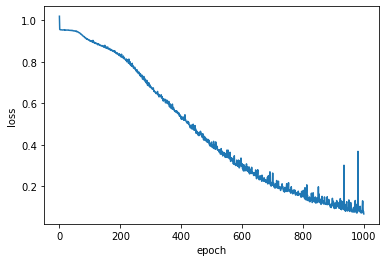

In [9]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

In [30]:
# for sleep scoring code -2 = Unscored, -1 = Artefact / Movement, 0 = Wake, 1 = N1 sleep, 1 = N2 sleep, 1 = N3 sleep, 2 = REM sleep
y_hat = []
for x in range(train_CH1.shape[0]):
    prediction = model.predict(train_CH1[x].reshape(1,1280))
    prediction_p = tf.nn.softmax(prediction)
    y_hat.append(np.argmax(prediction_p))

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


In [41]:
yhat = np.array(y_hat).reshape(2629,1)
equals = yhat==y
sum(equals)/2629

In [52]:
y_hat = []
for x in range(test_CH1.shape[0]):
    prediction = model.predict(test_CH1[x].reshape(1,1280))
    prediction_p = tf.nn.softmax(prediction)
    y_hat.append(np.argmax(prediction_p))

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


In [61]:
y=test_scores

In [62]:
y.shape

(879, 1)

In [63]:
yhat = np.array(y_hat).reshape(879,1)
equals = yhat==y
sum(equals)/879

array([0.71672355])